# 개, 고양이 분류(partial) - CNN v1
- 부분 데이터 
  - Train - 개 1000, 고양이 1000
  - Test - 개 500, 고양이 500
- 이미지 센터링 처리 안 함

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-06-08 11:58:08--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 173.194.203.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   272MB/s    in 0.2s    

2022-06-08 11:58:09 (272 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
!unzip cats_and_dogs_filtered.zip > /dev/null

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 탐색

In [6]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [7]:
# 파일 이름
import os
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])

['cat.408.jpg', 'cat.87.jpg', 'cat.667.jpg', 'cat.414.jpg', 'cat.260.jpg']
['dog.215.jpg', 'dog.439.jpg', 'dog.606.jpg', 'dog.87.jpg', 'dog.707.jpg']


In [8]:
# 파일 개수
len(train_cats_fnames), len(train_dogs_fnames)

(1000, 1000)

- 이미지 확인

In [9]:
fname = os.path.join(train_cats_dir, 'cat.475.jpg')
fname

'cats_and_dogs_filtered/train/cats/cat.475.jpg'

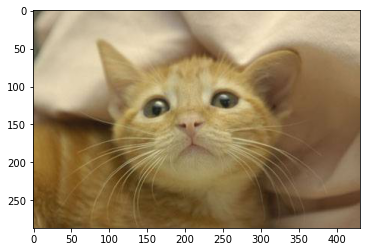

In [10]:
# 1) Pillow image
from PIL import Image
img = Image.open(fname)
plt.imshow(img);

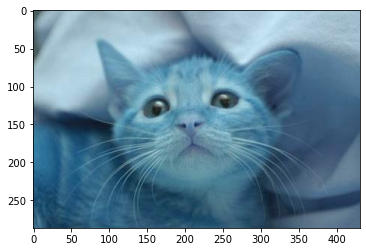

In [11]:
# 2) OpenCV image - BGR format
import cv2
img2 = cv2.imread(fname)
plt.imshow(img2);

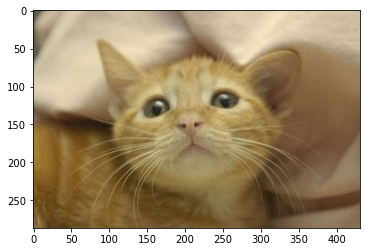

In [12]:
img2 = img2[:, :, ::-1]    # cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2);

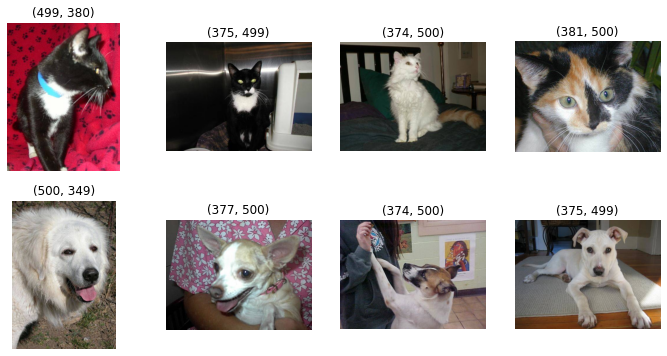

In [13]:
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:, :, ::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])

    plt.subplot(2, 4, i+5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:, :, ::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])
plt.show()

- 모델 구성

In [14]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
model = Sequential([Conv2D(16, (3, 3), input_shape=(150, 150, 3), activation='relu'),
                    MaxPooling2D(),
                    Conv2D(32, (3, 3), activation='relu'),
                    MaxPooling2D(),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [16]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-8),
              loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model_path = 'best_cats_dogs_v1.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

- 파일에서 이미지 데이터 읽어서 학습시키는 방법

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [19]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size=(150, 150))
test_generator = test_datagen.flow_from_directory(validation_dir, batch_size=20, class_mode='binary', target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- 모델 실행

In [20]:
hist = model.fit(train_generator, validation_data=test_generator, epochs=100, steps_per_epoch=100, validation_steps=50, callbacks=[mc, es])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.8041 - accuracy: 0.5660
Epoch 1: val_loss improved from inf to 0.63918, saving model to best_cats_dogs_v1.h5
100/100 [==============================] - 22s 91ms/step - loss: 0.8041 - accuracy: 0.5660 - val_loss: 0.6392 - val_accuracy: 0.6430
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.6780
Epoch 2: val_loss improved from 0.63918 to 0.59018, saving model to best_cats_dogs_v1.h5
100/100 [==============================] - 10s 96ms/step - loss: 0.6136 - accuracy: 0.6780 - val_loss: 0.5902 - val_accuracy: 0.6850
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.7305
Epoch 3: val_loss did not improve from 0.59018
100/100 [==============================] - 9s 88ms/step - loss: 0.5356 - accuracy: 0.7305 - val_loss: 0.7349 - val_accuracy: 0.6420
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 

In [21]:
best_model = load_model(model_path)

- 테스트 이미지 분류

In [22]:
from google.colab import files
up = files.upload()

Saving 개.jpg to 개.jpg
Saving 개1.jfif to 개1.jfif
Saving 개2.jpg to 개2.jpg
Saving 고양이.jpg to 고양이.jpg
Saving 고양이1.jpg to 고양이1.jpg
Saving 고양이2.jfif to 고양이2.jfif


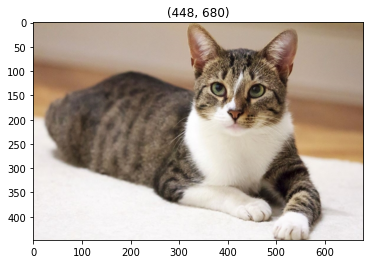

In [26]:
img = cv2.imread('고양이.jpg')[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]);

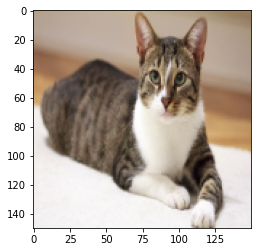

In [27]:
# 150 x 150 size
img = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_AREA)
plt.imshow(img);

In [30]:
best_model.predict(img.reshape(1, 150, 150, 3))

array([[1.]], dtype=float32)

In [31]:
for fname in up.keys():
    img = cv2.imread(fname)[:, :, ::-1]
    if sum(img.shape[:-1]) > 300:
        img = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_AREA)
    else:
        img = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
    classes = best_model.predict(img.reshape(1, 150, 150, 3))
    print(f"{classes[0, 0]: .4f} {fname} is a {'dog' if classes[0, 0] > 0.5 else 'cat'}")

 1.0000 개.jpg is a dog
 1.0000 개1.jfif is a dog
 0.0000 개2.jpg is a cat
 1.0000 고양이.jpg is a dog
 0.0000 고양이1.jpg is a cat
 0.0000 고양이2.jfif is a cat
